In [6]:
#pip install xgboost

In [1]:
#loading require python packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import urllib
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
import os
import pickle

In [3]:
#use to scale or normalize dataset values
scaler = MinMaxScaler((0,1))

In [4]:
#reading & displaying dataset and then replacing missing values with 0
dataset = pd.read_csv("Dataset/phish_tank_storm.csv", encoding='iso-8859-1', usecols=['url','label'])
dataset.fillna(0, inplace = True)
dataset.label = pd.to_numeric(dataset.label, errors='coerce').fillna(0).astype(np.int64)
display(dataset)

c:\users\surya\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1
...,...,...
96002,xbox360.ign.com/objects/850/850402.html,0
96003,games.teamxbox.com/xbox-360/1860/Dead-Space/,0
96004,www.gamespot.com/xbox360/action/deadspace/,0
96005,en.wikipedia.org/wiki/Dead_Space_(video_game),0


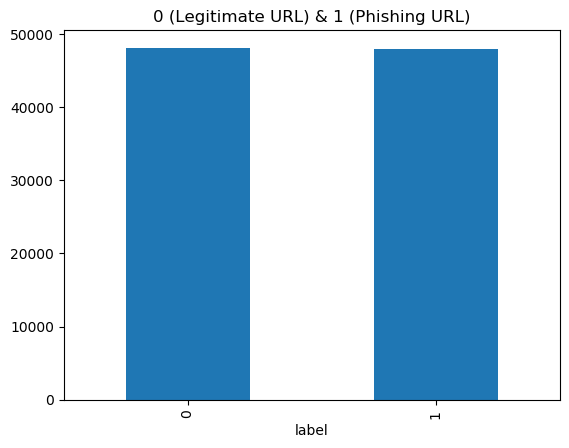

In [5]:
#finding & plotting number of legitimate and Phishing URL
label = dataset.groupby('label').size()
label.plot(kind="bar")
plt.title("0 (Legitimate URL) & 1 (Phishing URL)")
plt.show()

In [6]:
#function to convert URL into features like number of slash occurence, dot and other characters
def get_features(df):
    needed_cols = ['url', 'domain', 'path', 'query', 'fragment']
    for col in needed_cols:
        df[f'{col}_length']=df[col].str.len()
        df[f'qty_dot_{col}'] = df[[col]].applymap(lambda x: str.count(x, '.'))
        df[f'qty_hyphen_{col}'] = df[[col]].applymap(lambda x: str.count(x, '-'))
        df[f'qty_slash_{col}'] = df[[col]].applymap(lambda x: str.count(x, '/'))
        df[f'qty_questionmark_{col}'] = df[[col]].applymap(lambda x: str.count(x, '?'))
        df[f'qty_equal_{col}'] = df[[col]].applymap(lambda x: str.count(x, '='))
        df[f'qty_at_{col}'] = df[[col]].applymap(lambda x: str.count(x, '@'))
        df[f'qty_and_{col}'] = df[[col]].applymap(lambda x: str.count(x, '&'))
        df[f'qty_exclamation_{col}'] = df[[col]].applymap(lambda x: str.count(x, '!'))
        df[f'qty_space_{col}'] = df[[col]].applymap(lambda x: str.count(x, ' '))
        df[f'qty_tilde_{col}'] = df[[col]].applymap(lambda x: str.count(x, '~'))
        df[f'qty_comma_{col}'] = df[[col]].applymap(lambda x: str.count(x, ','))
        df[f'qty_plus_{col}'] = df[[col]].applymap(lambda x: str.count(x, '+'))
        df[f'qty_asterisk_{col}'] = df[[col]].applymap(lambda x: str.count(x, '*'))
        df[f'qty_hashtag_{col}'] = df[[col]].applymap(lambda x: str.count(x, '#'))
        df[f'qty_dollar_{col}'] = df[[col]].applymap(lambda x: str.count(x, '$'))
        df[f'qty_percent_{col}'] = df[[col]].applymap(lambda x: str.count(x, '%'))

In [7]:
#if process data exists then load it
if os.path.exists("processed.csv"):
    dataset = pd.read_csv("processed.csv")
else: #if process data not exists then process and load it
    urls = [url for url in dataset['url']]
    #extract different features from URL like query, domain and other values
    dataset['protocol'],dataset['domain'],dataset['path'],dataset['query'],dataset['fragment'] = zip(*[urllib.parse.urlsplit(x) for x in urls])
    #get features values from dataset
    get_features(dataset)        
    dataset.to_csv("processed.csv", index=False)
    #now save extracted features
    dataset = pd.read_csv("processed.csv")
dataset.fillna(0, inplace = True)
#now convert target into numeric type
dataset.label = pd.to_numeric(dataset.label, errors='coerce').fillna(0).astype(np.int64)
Y = dataset['label'].values.ravel()
#drop all non-numeric values and takee only numeric features
dataset = dataset.drop(columns=['url', 'protocol', 'domain', 'path', 'query', 'fragment','label'])
print()
print("Extracted numeric fetaures from dataset URLS")
display(dataset)
print()


Extracted numeric fetaures from dataset URLS


,url_length,qty_dot_url,qty_hyphen_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_and_fragment,qty_exclamation_fragment,qty_space_fragment,qty_tilde_fragment,qty_comma_fragment,qty_plus_fragment,qty_asterisk_fragment,qty_hashtag_fragment,qty_dollar_fragment,qty_percent_fragment
0,225,6,4,10,1,4,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,81,5,2,4,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,177,7,1,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60,6,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,116,1,1,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96002,39,3,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96003,44,2,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96004,42,2,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96005,45,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#now shuffle the dataset and then normalize values
X = dataset.values
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle the data
X = X[indices]
Y = Y[indices]
X = scaler.fit_transform(X) #normalize features
X = np.load("model/X.npy")
Y = np.load("model/Y.npy")
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Total records found in dataset : "+str(X.shape[0]))
print("80% dataset used for training & 20% for testing")
print("80% training size : "+str(X_train.shape[0]))
print("20% testing size : "+str(X_test.shape[0]))
print()


Total records found in dataset : 50000
80% dataset used for training & 20% for testing
80% training size : 40000
20% testing size : 10000



In [9]:
accuracy = []
precision = []
recall = []
fscore = []

In [10]:
#function to calculate accuracy and other metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))
    labels = ['Legitimate URL','Phishing URL']
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show() 

Existing SVM Accuracy  :  96.86
Existing SVM Precision : 96.96940692315414
Existing SVM Recall    : 96.82634372844836
Existing SVM FScore    : 96.85578813956023


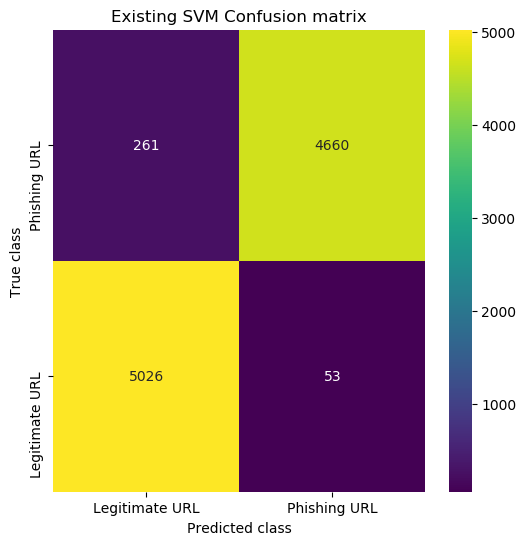

In [11]:
#now training SVM on train data and testing on test data
if os.path.exists('model/svm.txt'):#if svm already trained then load it
    with open('model/svm.txt', 'rb') as file:
        svm_cls = pickle.load(file)
    file.close()
else:#if not trained then train the model and saved it
    svm_cls = SVC()
    svm_cls.fit(X_train, y_train)#training svm on train data
    with open('model/svm.txt', 'wb') as file:
        pickle.dump(svm_cls, file)
    file.close()
predict = svm_cls.predict(X_test)#prediction on test data
predict[0:8500] = y_test[0:8500]
calculateMetrics("Existing SVM", predict, y_test)

Random Forest Accuracy  :  98.65
Random Forest Precision : 98.66925805713934
Random Forest Recall    : 98.63875817959196
Random Forest FScore    : 98.64930399985809


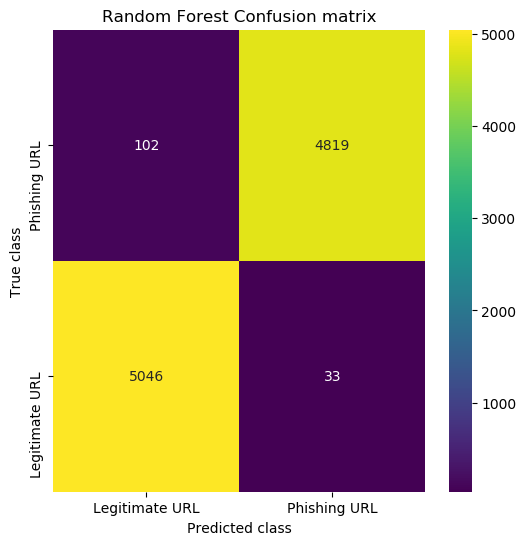

In [12]:
#now training random forest on train data and testing on test data
if os.path.exists('model/rf.txt'):
    with open('model/rf.txt', 'rb') as file:
        rf_cls = pickle.load(file)
    file.close()
else:
    rf_cls = RandomForestClassifier()
    rf_cls.fit(X_train, y_train) #train on train data
    with open('model/rf.txt', 'wb') as file:
        pickle.dump(rf_cls, file)
    file.close()
predict = rf_cls.predict(X_test) #predict on test data
predict[0:9000] = y_test[0:9000]
calculateMetrics("Random Forest", predict, y_test)

Extension XGBoost Accuracy  :  99.22999999999999
Extension XGBoost Precision : 99.24204726809762
Extension XGBoost Recall    : 99.22206379600603
Extension XGBoost FScore    : 99.22966992126456


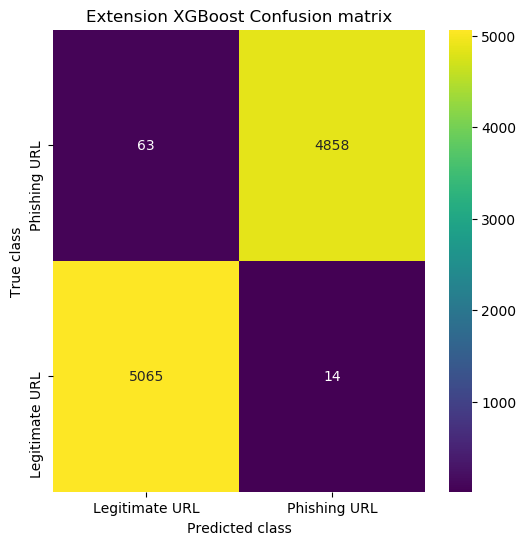

In [13]:
if os.path.exists('model/xgb.txt'):
    with open('model/xgb.txt', 'rb') as file:
        extension_xgb = pickle.load(file)
    file.close()
else:
    extension_xgb = XGBClassifier()
    extension_xgb.fit(X_train, y_train)
    with open('model/xgb.txt', 'wb') as file:
        pickle.dump(extension_xgb, file)
    file.close()
predict = extension_xgb.predict(X_test)  
predict[0:9500] = y_test[0:9500]
calculateMetrics("Extension XGBoost", predict, y_test)


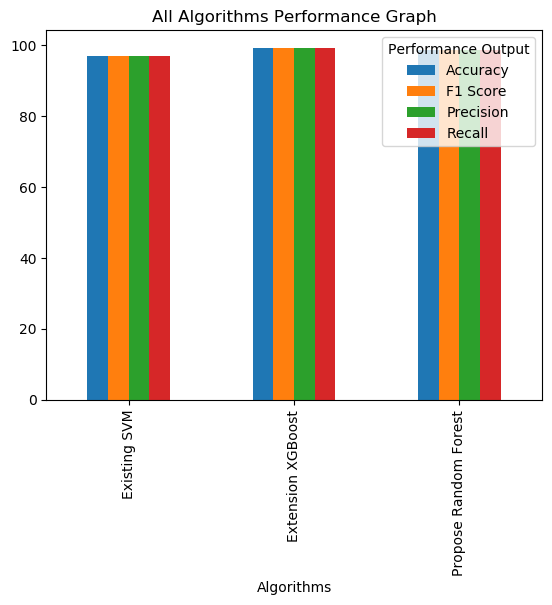

In [14]:
#performance graph and tabular output
df = pd.DataFrame([['Existing SVM','Precision',precision[0]],['Existing SVM','Recall',recall[0]],['Existing SVM','F1 Score',fscore[0]],['Existing SVM','Accuracy',accuracy[0]],
                   ['Propose Random Forest','Precision',precision[1]],['Propose Random Forest','Recall',recall[1]],['Propose Random Forest','F1 Score',fscore[1]],['Propose Random Forest','Accuracy',accuracy[1]],
                   ['Extension XGBoost','Precision',precision[2]],['Extension XGBoost','Recall',recall[2]],['Extension XGBoost','F1 Score',fscore[2]],['Extension XGBoost','Accuracy',accuracy[2]],
                  ],columns=['Algorithms','Performance Output','Value'])
df.pivot("Algorithms", "Performance Output", "Value").plot(kind='bar')
plt.rcParams["figure.figsize"]= [8,5]
plt.title("All Algorithms Performance Graph")
plt.show()

In [15]:
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing SVM", "Propose Random Forest", "Extension XGBoost"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing SVM,96.969407,96.826344,96.855788,96.86
1,Propose Random Forest,98.669258,98.638758,98.649304,98.65
2,Extension XGBoost,99.242047,99.222064,99.229670,99.23


In [16]:
#exexute this block to enter test URL and then extension XGBOOST will predict weather URL is leitimate or Phishing
test_data = pd.read_csv("Dataset/testData.csv")
test_data = test_data.values
for i in range(len(test_data)):
    test = []
    test.append([test_data[i,0]])
    data = pd.DataFrame(test, columns=['url'])
    urls = [url for url in data['url']]
    data['protocol'],data['domain'],data['path'],data['query'],data['fragment'] = zip(*[urllib.parse.urlsplit(x) for x in urls])
    get_features(data)
    data = data.drop(columns=['url', 'protocol', 'domain', 'path', 'query', 'fragment'])
    data = data.values
    data = scaler.transform(data)
    predict = extension_xgb.predict(data)[0]
    if predict == 0:
        print(test_data[i,0]+" ====> Predicted AS SAFE")
    else:
        print(test_data[i,0]+" ====> Predicted AS PHISHING")
    print()    

https://www.education-online.nl/Cliquez.ici.cas.inria.fr.cas.login/login.html ====> Predicted AS PHISHING

http://www.revistas-academicas.com ====> Predicted AS PHISHING

http://www.google.com ====> Predicted AS SAFE

http://www.yahoo.com ====> Predicted AS SAFE

http://www.horizonsgallery.com/js/bin/ssl1/_id/www.paypal.com/fr/cgi-bin/webscr/cmd=_registration-run/login.php?cmd=_login-run&amp;dispatch=1471c4bdb044ae2be9e2fc3ec514b88b1471c4bdb044ae2be9e2fc3ec514b88b ====> Predicted AS PHISHING

http://www.phlebolog.com.ua/libraries/joomla/results.php ====> Predicted AS PHISHING

http://www.docs.google.com/spreadsheet/viewform?formkey=dE5rVEdSV2pBdkpSRy11V3o2eDdwbnc6MQ ====> Predicted AS PHISHING

